**Constraints = All earlier constraints + Multimodal time constraint + Multimodal budget constraint + Itiernary visualization + Configuration_file + New Ordereing Constraint Checked**

1. City
2. time_budget
3. cost_budget

In [3]:
from gurobipy import Model, GRB, quicksum
import pandas as pd
import json

## READING JSON FILE INPUTS

In [5]:
# Load JSON configuration
config_file = "config.json"

In [6]:
with open(config_file, "r") as file:
    config = json.load(file)

In [7]:
# Extract user inputs
city = config.get("city", "").strip()
time_budget = config.get("time_budget", 0)
cost_budget = config.get("cost_budget", 0)

In [8]:
# Extract source and destination coordinates (assumed list format: [latitude, longitude])
source = config.get("source")
destination = config.get("destination")

source_lat = float(source[0])
source_lon = float(source[1])

dest_lat = float(destination[0])
dest_lon = float(destination[1])

# Paths to Excel files
utility_data_path = "/Users/priyanshukumarjha/Desktop/Itinerary Data/Cities/Updated Travel Data .xlsx"
cost_data_path = "/Users/priyanshukumarjha/Desktop/Itinerary Data/Cities/Cost Data.xlsx"

utility = pd.read_excel(utility_data_path, sheet_name=city)
cost_data = pd.read_excel(cost_data_path, sheet_name=city)

print("City:", city)
print("Time Budget:", time_budget)
print("Cost Budget:", cost_budget)
print("Source Coordinates:", (source_lat, source_lon))
print("Destination Coordinates:", (dest_lat, dest_lon) )


City: Osaka
Time Budget: 480
Cost Budget: 5000
Source Coordinates: (34.655, 135.43)
Destination Coordinates: (34.645, 135.504)


In [9]:
cost_data.shape

(702, 5)

In [10]:
cost_data["from"].value_counts()

from
1     26
17    26
28    26
27    26
26    26
25    26
24    26
23    26
22    26
21    26
20    26
19    26
18    26
16    26
2     26
15    26
12    26
11    26
10    26
9     26
8     26
7     26
6     26
5     26
4     26
3     26
29    26
Name: count, dtype: int64

In [11]:
cost_data[cost_data["from"]==31]

,from,to,cost,profit,category


## DATA PREPARATION

In [13]:
import math
import pandas as pd

# Example Haversine function returning distance in meters
def haversine_distance_meters(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points (lat1, lon1) and
    (lat2, lon2) on Earth in meters.
    """
    # Radius of Earth in meters
    R = 6371000  # ~6,371 km in meters

    # Convert degrees to radians
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    # Haversine formula
    a = (math.sin(d_lat / 2) ** 2
         + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2) ** 2)
    c = 2 * math.asin(math.sqrt(a))

    # Distance in meters
    distance_meters = R * c
    return distance_meters

# Add distance columns (in meters) to the DataFrame
utility["distance from source"] = utility.apply(
    lambda row: haversine_distance_meters(source_lat, source_lon, row["lat"], row["long"]),
    axis=1
)

utility["distance from destination"] = utility.apply(
    lambda row: haversine_distance_meters(dest_lat, dest_lon, row["lat"], row["long"]),
    axis=1
)


In [14]:
utility

,poiID,poiName,lat,long,theme,Avg Visiting TIme,Utility Score,fees,opening time,closing time,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,distance from source,distance from destination
0,1,Osaka_Aquarium_Kaiyukan,34.654472,135.428889,Amusement,180,886,1320,10:00:00,20:00:00,1,1,1,1,1,1,1,117.362006,6950.943233
1,2,Tempozan_Ferris_Wheel,34.656166,135.431031,Amusement,30,253,440,10:00:00,21:00:00,1,1,1,1,1,0,0,160.294538,6789.170552
2,3,Tennoji_Zoo,34.652556,135.508496,Amusement,120,599,275,09:30:00,17:00:00,0,1,1,1,1,1,1,7185.113862,935.446909
3,4,Universal_Studios_Japan,34.664720,135.433060,Amusement,480,512,4730,09:00:00,21:00:00,1,1,1,1,1,1,1,1116.463463,6849.236366
4,5,HEP_Five,34.704003,135.500447,Amusement,150,315,330,11:00:00,22:45:00,1,1,1,1,1,1,1,8437.155418,6568.854086
5,6,Umeda_Sky_Building,34.705280,135.489720,Amusement,120,660,825,09:30:00,22:30:00,1,1,1,1,1,1,1,7815.264838,6828.847798
6,7,Nakanoshima_Park,34.693056,135.506431,Park,120,197,0,00:00:00,23:59:00,1,1,1,1,1,1,1,8170.566621,5348.206249
7,8,Osaka_Castle,34.687220,135.525830,Park,180,1307,330,09:00:00,17:00:00,1,1,1,1,1,1,1,9467.714167,5101.534871
8,9,Sumiyoshi_Park,34.612400,135.488480,Park,120,5,0,00:00:00,23:59:00,1,1,1,1,1,1,1,7145.994576,3893.172033
9,10,Tennoji Park,34.649850,135.511110,Park,180,412,85,07:00:00,22:00:00,0,1,1,1,1,1,1,7441.261905,844.899436


In [15]:
utility['fees'].value_counts()

fees
0       18
330      2
1320     1
440      1
275      1
4730     1
825      1
85       1
165      1
Name: count, dtype: int64

In [16]:
utility['fees'].describe()

count      27.000000
mean      314.814815
std       933.180543
min         0.000000
25%         0.000000
50%         0.000000
75%       220.000000
max      4730.000000
Name: fees, dtype: float64

In [17]:
utility['fees'].sum()

8500

In [18]:
utility['Utility Score'].sum()

7747

In [19]:
utility.shape

(27, 19)

In [20]:
cost_data.shape

(702, 5)

In [21]:
# Extract relevant data
poi_ids = utility['poiID'].tolist()

In [22]:
poi_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [23]:
poi_ids = [0] + poi_ids + [poi_ids[-1] + 1]

In [24]:
poi_ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

## APPENDING SOURCE COST DATA IN COST_DATA DATAFRAME

In [26]:
new_df = utility[['poiID', 'distance from source']].copy()

In [27]:
new_df

,poiID,distance from source
0,1,117.362006
1,2,160.294538
2,3,7185.113862
3,4,1116.463463
4,5,8437.155418
5,6,7815.264838
6,7,8170.566621
7,8,9467.714167
8,9,7145.994576
9,10,7441.261905


In [28]:
new_df.insert(0,'from',0)

In [29]:
new_df.rename(columns={'poiID': 'to', 'distance from source': 'cost'}, inplace=True)

In [30]:
poi_dict = dict(zip(utility["poiID"], utility["theme"]))

In [31]:
profit_dict = dict(zip(utility["poiID"], utility["Utility Score"]))

In [32]:
new_df['profit'] = new_df['to'].map(profit_dict)
new_df['category'] = new_df['to'].map(poi_dict)

In [33]:
# Step 1: Make a copy of new_df
reversed_df = new_df.copy()

# Step 2: Swap the 'from' and 'to' columns
reversed_df['from'], reversed_df['to'] = reversed_df['to'], reversed_df['from']

# Step 3: Set profit to 0 and category to 'hotel'
reversed_df['profit'] = 0
reversed_df['category'] = 'hotel'

# Step 4: Append reversed_df to new_df
new_df = pd.concat([new_df, reversed_df], ignore_index=True)

# Now new_df contains both (i -> j) and (j -> i) rows.

## APPENDING DESTINATION COST DATA IN COST_DATA DATAFRAME

In [35]:
new_df_dest = utility[['poiID', 'distance from destination']].copy()

In [36]:
new_df_dest

,poiID,distance from destination
0,1,6950.943233
1,2,6789.170552
2,3,935.446909
3,4,6849.236366
4,5,6568.854086
5,6,6828.847798
6,7,5348.206249
7,8,5101.534871
8,9,3893.172033
9,10,844.899436


In [37]:
new_df_dest.insert(0, 'from', poi_ids[-1])

In [38]:
new_df_dest.rename(columns={'poiID': 'to', 'distance from destination': 'cost'}, inplace=True)

In [39]:
new_df_dest['profit'] = new_df_dest['to'].map(profit_dict)
new_df_dest['category'] = new_df_dest['to'].map(poi_dict)

In [40]:
# Step 1: Make a copy of new_df_dest
reversed_df_dest = new_df_dest.copy()

# Step 2: Swap the 'from' and 'to' columns
reversed_df_dest['from'], reversed_df_dest['to'] = reversed_df_dest['to'], reversed_df_dest['from']

# Step 3: Set profit to 0 and category to 'hotel'
reversed_df_dest['profit'] = 0
reversed_df_dest['category'] = 'hotel'

# Step 4: Append reversed_df_dest to new_df_dest
new_df_dest = pd.concat([new_df_dest, reversed_df_dest], ignore_index=True)

# Now new_df_dest contains both (i -> j) and (j -> i) rows.

In [41]:
cost_data = pd.concat([cost_data, new_df, new_df_dest], ignore_index=True)

## ADDING SOURCE POI TO DESTINATION POI AND VICE VERSA TO COST_DATA

In [43]:
# 1. Calculate distances using your Haversine function
distance_0_end_poi = haversine_distance_meters(source_lat, source_lon, dest_lat, dest_lon)


# 2. Create new rows as a list of dictionaries
rows_to_add = [
    {
        'from': 0,
        'to': poi_ids[-1],
        'cost': distance_0_end_poi,
        'profit': 0,
        'category': 'hotel'
    },
    {
        'from': poi_ids[-1],
        'to': 0,
        'cost': distance_0_end_poi,
        'profit': 0,
        'category': 'hotel'
    }
]

# 3. Convert that list into a small DataFrame
new_rows_df = pd.DataFrame(rows_to_add)

# 4. Concatenate with your existing cost_data
cost_data = pd.concat([cost_data, new_rows_df], ignore_index=True)


In [44]:
utility.drop(columns=['distance from source','distance from destination'], inplace = True)

In [45]:
cost_data.sort_values(by=['from', 'to'], ascending=[True, True], inplace=True)

## APPENDING SOURCE AND DESTINATION ROWS IN UTILITY DATAFRAME

In [47]:
# Create new rows as a list of dictionaries
import datetime
rows_to_add = [
    {
        'poiID': 0,
        'poiName': 'source',
        'lat': source_lat,
        'long': source_lon,
        'theme': 'hotel',
        'Avg Visiting TIme': 0,
        'Utility Score': 0,
        'fees': 0,
        'opening time': datetime.time(hour=0, minute=0, second=0),
        'closing time': datetime.time(hour=23, minute=59, second=59),
        'Monday': 1,
        'Tuesday': 1,
        'Wednesday': 1,
        'Thursday': 1,
        'Friday': 1,
        'Saturday': 1,
        'Sunday': 1,
    },
    {
        'poiID': poi_ids[-1],
        'poiName': 'destination',
        'lat': dest_lat,
        'long': dest_lon,
        'theme': 'hotel',
        'Avg Visiting TIme': 0,
        'Utility Score': 0,
        'fees': 0,
        'opening time': datetime.time(hour=0, minute=0, second=0),
        'closing time': datetime.time(hour=23, minute=59, second=59),
        'Monday': 1,
        'Tuesday': 1,
        'Wednesday': 1,
        'Thursday': 1,
        'Friday': 1,
        'Saturday': 1,
        'Sunday': 1,
    }
]

# 3. Convert that list into a small DataFrame
new_rows_df = pd.DataFrame(rows_to_add)

# 4. Concatenate with your existing cost_data
utility = pd.concat([utility, new_rows_df], ignore_index=True)

In [48]:
utility.sort_values(by = 'poiID', inplace = True)

In [49]:
utility

,poiID,poiName,lat,long,theme,Avg Visiting TIme,Utility Score,fees,opening time,closing time,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
27,0,source,34.655000,135.430000,hotel,0,0,0,00:00:00,23:59:59,1,1,1,1,1,1,1
0,1,Osaka_Aquarium_Kaiyukan,34.654472,135.428889,Amusement,180,886,1320,10:00:00,20:00:00,1,1,1,1,1,1,1
1,2,Tempozan_Ferris_Wheel,34.656166,135.431031,Amusement,30,253,440,10:00:00,21:00:00,1,1,1,1,1,0,0
2,3,Tennoji_Zoo,34.652556,135.508496,Amusement,120,599,275,09:30:00,17:00:00,0,1,1,1,1,1,1
3,4,Universal_Studios_Japan,34.664720,135.433060,Amusement,480,512,4730,09:00:00,21:00:00,1,1,1,1,1,1,1
4,5,HEP_Five,34.704003,135.500447,Amusement,150,315,330,11:00:00,22:45:00,1,1,1,1,1,1,1
5,6,Umeda_Sky_Building,34.705280,135.489720,Amusement,120,660,825,09:30:00,22:30:00,1,1,1,1,1,1,1
6,7,Nakanoshima_Park,34.693056,135.506431,Park,120,197,0,00:00:00,23:59:00,1,1,1,1,1,1,1
7,8,Osaka_Castle,34.687220,135.525830,Park,180,1307,330,09:00:00,17:00:00,1,1,1,1,1,1,1
8,9,Sumiyoshi_Park,34.612400,135.488480,Park,120,5,0,00:00:00,23:59:00,1,1,1,1,1,1,1


## CREATING REQUIRED DATA STRUCTURES

In [51]:
visit_times = dict(zip(utility['poiID'], utility['Avg Visiting TIme']))
utility_scores = dict(zip(utility['poiID'], utility['Utility Score']))

In [52]:
# Create a dictionary for travel times in minutes (cost in meters converted to km then multiplied by 15)
travel_times_walking = {(row['from'], row['to']): (row['cost'] / 1000) * 15 for _, row in cost_data.iterrows()}
travel_times_taxi = {(row['from'], row['to']): (row['cost'] / 1000) * 2 for _, row in cost_data.iterrows()}

In [53]:
# Extract opening and closing times into dictionaries
opening_times = utility.set_index("poiID")["opening time"].to_dict()
closing_times = utility.set_index("poiID")["closing time"].to_dict()

In [54]:
opening_times

{0: datetime.time(0, 0),
 1: datetime.time(10, 0),
 2: datetime.time(10, 0),
 3: datetime.time(9, 30),
 4: datetime.time(9, 0),
 5: datetime.time(11, 0),
 6: datetime.time(9, 30),
 7: datetime.time(0, 0),
 8: datetime.time(9, 0),
 9: datetime.time(0, 0),
 10: datetime.time(7, 0),
 11: datetime.time(0, 0),
 12: datetime.time(0, 0),
 15: datetime.time(8, 30),
 16: datetime.time(0, 0),
 17: datetime.time(8, 0),
 18: datetime.time(8, 0),
 19: datetime.time(0, 0),
 20: datetime.time(0, 0),
 21: datetime.time(0, 0),
 22: datetime.time(0, 0),
 23: datetime.time(10, 0),
 24: datetime.time(11, 0),
 25: datetime.time(11, 0),
 26: datetime.time(10, 0),
 27: datetime.time(0, 0),
 28: datetime.time(18, 0),
 29: datetime.time(10, 0),
 30: datetime.time(0, 0)}

In [55]:
travel_times_walking

{(0, 1): 1.7604300847290022,
 (0, 2): 2.404418076196481,
 (0, 3): 107.77670793170883,
 (0, 4): 16.74695194567772,
 (0, 5): 126.5573312666677,
 (0, 6): 117.22897256290605,
 (0, 7): 122.5584993179964,
 (0, 8): 142.0157125080019,
 (0, 9): 107.18991863525933,
 (0, 10): 111.61892858127054,
 (0, 11): 99.65434113281903,
 (0, 12): 143.54203981686558,
 (0, 15): 118.62601670668877,
 (0, 16): 111.42829265330973,
 (0, 17): 142.47270793756923,
 (0, 18): 132.38307163938453,
 (0, 19): 73.09228122125126,
 (0, 20): 98.54913606037384,
 (0, 21): 100.36915616886571,
 (0, 22): 104.52901000349917,
 (0, 23): 104.33467581467754,
 (0, 24): 97.49102064898051,
 (0, 25): 129.93873302571407,
 (0, 26): 6155.898353395909,
 (0, 27): 97.91101703924656,
 (0, 28): 128.24619305449977,
 (0, 29): 105.03789321978836,
 (0, 30): 102.89635902640687,
 (1, 0): 1.7604300847290022,
 (1, 2): 4.08099559867857,
 (1, 3): 109.3934236597017,
 (1, 4): 18.04551505524765,
 (1, 5): 128.43386852141535,
 (1, 6): 119.0581084625625,
 (1, 7): 12

In [56]:
travel_times_taxi

{(0, 1): 0.2347240112972003,
 (0, 2): 0.32058907682619747,
 (0, 3): 14.370227724227844,
 (0, 4): 2.2329269260903626,
 (0, 5): 16.874310835555693,
 (0, 6): 15.63052967505414,
 (0, 7): 16.34113324239952,
 (0, 8): 18.935428334400253,
 (0, 9): 14.291989151367911,
 (0, 10): 14.882523810836071,
 (0, 11): 13.28724548437587,
 (0, 12): 19.138938642248743,
 (0, 15): 15.816802227558503,
 (0, 16): 14.857105687107964,
 (0, 17): 18.996361058342565,
 (0, 18): 17.651076218584603,
 (0, 19): 9.745637496166834,
 (0, 20): 13.139884808049846,
 (0, 21): 13.382554155848762,
 (0, 22): 13.937201333799889,
 (0, 23): 13.911290108623671,
 (0, 24): 12.9988027531974,
 (0, 25): 17.32516440342854,
 (0, 26): 820.7864471194546,
 (0, 27): 13.054802271899542,
 (0, 28): 17.099492407266634,
 (0, 29): 14.005052429305115,
 (0, 30): 13.71951453685425,
 (1, 0): 0.2347240112972003,
 (1, 2): 0.544132746490476,
 (1, 3): 14.58578982129356,
 (1, 4): 2.4060686740330204,
 (1, 5): 17.12451580285538,
 (1, 6): 15.874414461675,
 (1, 7): 

In [57]:
# Define taxi cost per meter (90 rupees per km = 90/1000 rupees per meter)
taxi_cost_per_meter = 300/ 1000  

## MODEL DECLARATION, VARIABLES & OBJECTIVE FUNCTION

In [59]:
model = Model("ILP_Model_1")

Set parameter Username
Set parameter LicenseID to value 2616933
Academic license - for non-commercial use only - expires 2026-01-31


In [60]:
# Decision variables: y[i] = 1 if POI i is included in the itinerary, 0 otherwise
y = model.addVars(poi_ids, vtype=GRB.BINARY, name="y")

In [61]:
# Introduce new binary variables for travel between POIs
z = model.addVars(poi_ids, poi_ids, vtype=GRB.BINARY, name="z")

In [62]:
start_time = model.addVar(vtype=GRB.CONTINUOUS, name="start_time")

In [63]:
arrival_time = model.addVars(poi_ids, vtype=GRB.CONTINUOUS, name="arrival_time")

In [64]:
N = len(poi_ids)  # Total number of POIs

# Create continuous variables for the position of each POI in the sequence
p = model.addVars(poi_ids, vtype=GRB.CONTINUOUS, lb=2, ub=N, name="p")

In [65]:
N

29

In [66]:
w = model.addVars(poi_ids, poi_ids, vtype=GRB.BINARY, name="w")  # Walking
x = model.addVars(poi_ids, poi_ids, vtype=GRB.BINARY, name="x")  # Taxi

In [67]:
# Objective: Maximize the sum of utility scores for selected POIs
model.setObjective(quicksum(utility_scores[i] * y[i] for i in poi_ids), GRB.MAXIMIZE)

## MODE SELECTION CONSTRAINT

In [69]:
# Ensure only one mode is chosen for travel between i and j
model.addConstrs((z[i, j] == w[i, j] + x[i, j] for i in poi_ids for j in poi_ids if i != j), name="MultimodalChoice")
model.addConstrs((z[i, j] <= 1 for i in poi_ids for j in poi_ids if i != j), name="SingleModeLimit")

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model Update*>,
 (0, 20): <gurobi.Constr *Awaiting Model Update*>,
 (0, 21): <gurobi.Constr *Awaiting Model Update*>,
 (0, 22): <gurobi.Constr *Awaiting Model

## LOGICAL CONNECTION BETWEEN Y AND Z

In [71]:
# Additional constraint: Ensure logical connection between y[i] and z[i, j]
for i in poi_ids:
    for j in poi_ids:
        if i != j:
            model.addConstr(z[i, j] <= y[i], name=f"TravelStartsFrom_{i}_{j}")
            model.addConstr(z[i, j] <= y[j], name=f"TravelEndsAt_{i}_{j}")

## TIME CONSTRAINT

In [73]:
model.addConstr(
    quicksum(travel_times_walking.get((i, j), 0) * w[i, j] for i in poi_ids for j in poi_ids if i != j) +
    quicksum(travel_times_taxi.get((i, j), 0) * x[i, j] for i in poi_ids for j in poi_ids if i != j) +
    quicksum(visit_times[i] * y[i] for i in poi_ids) <= time_budget,
    name="TimeConstraint"
)

<gurobi.Constr *Awaiting Model Update*>

## CATEGORY CONSTRAINT

In [75]:
# Define lower and upper bounds for each theme
theme_bounds = {
    # "Palace": (1, 3),
    # "Park": (1, 2),
    # "Museum": (3, 11),
    # "zoo":(0,5),
    # "Shopping":(0,3)
}

# Add constraints for each theme
for theme, (lower_bound, upper_bound) in theme_bounds.items():
    # Sum up the binary variables y[i] for all POIs belonging to the current theme
    theme_count = quicksum(y[i] for i in poi_ids if i - 1 < len(utility) and utility.iloc[i - 1]["theme"] == theme)

    
    # Add lower and upper bound constraints
    model.addConstr(theme_count >= lower_bound, name=f"Min_{theme}")
    model.addConstr(theme_count <= upper_bound, name=f"Max_{theme}")


## ORDERING CONSTRAINT

In [77]:
# List of ordering constraints in the form of (a, b)
ordering_constraints = []  

In [78]:
M = N+10  # A sufficiently large number

for (a, b) in ordering_constraints:
    model.addConstr(
        p[a] + 1 <= p[b] + M * (1 - y[a]) + M * (1 - y[b]), 
        name=f"Ordering_{a}_before_{b}"
    )

In [79]:
# # Constraint: POI 1 must always be part of the itinerary (start point)
# model.addConstr(y[starting_poi] == 1, name="StartPoint")

# # Constraint: POI 8 must always be part of the itinerary (end point)
# model.addConstr(y[ending_poi] == 1, name="EndPoint")

## STARTING AND ENDING CONSTRAINT (ALWAYS INCLUDE THEM IN ITINERARY)

In [81]:
starting_poi = poi_ids[0]
ending_poi = poi_ids[-1]

In [82]:
# Start point: Exactly one outgoing edge from node SOURCE
model.addConstr(quicksum(z[starting_poi, j] for j in poi_ids if j != starting_poi) == 1, name="StartConstraint")

# End point: Exactly one incoming edge to node DESTINATION
model.addConstr(quicksum(z[i, ending_poi] for i in poi_ids if i != ending_poi) == 1, name="EndConstraint")

<gurobi.Constr *Awaiting Model Update*>

## CONNECTIVITY CONSTRAINT

In [84]:
# Connectivity: Each intermediate POI must have exactly one incoming and one outgoing edge if it is selected
for k in poi_ids:
    if k not in [starting_poi, ending_poi]:  # Skip start and end points
        model.addConstr(quicksum(z[i, k] for i in poi_ids if i != k) == y[k], name=f"FlowIn_{k}")
        model.addConstr(quicksum(z[k, j] for j in poi_ids if j != k) == y[k], name=f"FlowOut_{k}")

## SUBTOUR ELIMINATION CONSTRAINT

In [86]:
# Add the subtour elimination constraints
for i in poi_ids:
    for j in poi_ids:
        if i != j and i > starting_poi and j > starting_poi:  # Skip the start and end POIs
            model.addConstr(
                p[i] - p[j] + 1 <= (N - 1) * (1 - z[i, j]),
                name=f"SubtourElimination_{i}_{j}"
            )

## NO OUTGOING EDGE FROM ENDING POI CONSTRAINT

In [88]:
# No outgoing edges from POI 39 (end POI)
model.addConstr(quicksum(z[ending_poi, j] for j in poi_ids if j != ending_poi) == 0, name="NoOutgoingFromEnd")

<gurobi.Constr *Awaiting Model Update*>

## COST BUDGET CONSTRAINT

In [90]:
# Extract valid (i, j) pairs from cost_data
valid_edges = set(zip(cost_data["from"], cost_data["to"]))

# Create a dictionary mapping POI to its entrance fee from utility
fees_dict = utility.set_index("poiID")["fees"].to_dict()

# Add constraint: Total travel cost (taxi) + entrance fee cost ≤ cost_budget
model.addConstr(
    quicksum(
        cost_data.loc[(cost_data["from"] == i) & (cost_data["to"] == j), "cost"].values[0] * taxi_cost_per_meter * x[i, j]
        for i, j in valid_edges  # Ensures only valid (i, j) pairs are used
    ) +
    quicksum(
        fees_dict.get(i, 0) * y[i]  # Use y[i] to ensure entrance fees are counted only if POI is included
        for i in poi_ids
    ) <= cost_budget,
    "CostBudgetConstraint"
)


<gurobi.Constr *Awaiting Model Update*>

## OPENING CLOSING TIME CONSTRAINT

In [92]:
def convert_to_minutes(time_obj):
    return time_obj.hour * 60 + time_obj.minute

opening_times = {i: convert_to_minutes(t) for i, t in opening_times.items()}
closing_times = {i: convert_to_minutes(t) for i, t in closing_times.items()}


In [93]:
opening_times

{0: 0,
 1: 600,
 2: 600,
 3: 570,
 4: 540,
 5: 660,
 6: 570,
 7: 0,
 8: 540,
 9: 0,
 10: 420,
 11: 0,
 12: 0,
 15: 510,
 16: 0,
 17: 480,
 18: 480,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 600,
 24: 660,
 25: 660,
 26: 600,
 27: 0,
 28: 1080,
 29: 600,
 30: 0}

In [94]:
#start_time is declared as a continuous variable, meaning it can take any real value between 420 (7:00 AM) and 600 (10:00 AM).
#The solver will treat start_time as a decision variable and explore all possible values in that range to find the optimal one that satisfies the objective and other constraints.

model.addConstr(start_time == 600, name="StartAfter10AM")

# model.addConstr(start_time >= 480, name="StartAfter8AM")  # 480 minutes = 8 AM
# model.addConstr(start_time <= 600, name="StartBefore10AM")  # 600 minutes = 10 AM

<gurobi.Constr *Awaiting Model Update*>

In [95]:
model.addConstr(arrival_time[starting_poi] == start_time, name="StartTimeAtSource")

<gurobi.Constr *Awaiting Model Update*>

In [96]:
for i in poi_ids:
    for j in poi_ids:
        if i != j:
            model.addConstr(
                arrival_time[i] >= (arrival_time[j] + visit_times[j] + (travel_times_walking.get((j, i), 0) * w[j, i] + travel_times_taxi.get((j, i), 0) * x[j, i])) * z[j, i],
                name=f"ArrivalTime_{j}_to_{i}"
            )

In [97]:
arrival_time

{0: <gurobi.Var *Awaiting Model Update*>,
 1: <gurobi.Var *Awaiting Model Update*>,
 2: <gurobi.Var *Awaiting Model Update*>,
 3: <gurobi.Var *Awaiting Model Update*>,
 4: <gurobi.Var *Awaiting Model Update*>,
 5: <gurobi.Var *Awaiting Model Update*>,
 6: <gurobi.Var *Awaiting Model Update*>,
 7: <gurobi.Var *Awaiting Model Update*>,
 8: <gurobi.Var *Awaiting Model Update*>,
 9: <gurobi.Var *Awaiting Model Update*>,
 10: <gurobi.Var *Awaiting Model Update*>,
 11: <gurobi.Var *Awaiting Model Update*>,
 12: <gurobi.Var *Awaiting Model Update*>,
 15: <gurobi.Var *Awaiting Model Update*>,
 16: <gurobi.Var *Awaiting Model Update*>,
 17: <gurobi.Var *Awaiting Model Update*>,
 18: <gurobi.Var *Awaiting Model Update*>,
 19: <gurobi.Var *Awaiting Model Update*>,
 20: <gurobi.Var *Awaiting Model Update*>,
 21: <gurobi.Var *Awaiting Model Update*>,
 22: <gurobi.Var *Awaiting Model Update*>,
 23: <gurobi.Var *Awaiting Model Update*>,
 24: <gurobi.Var *Awaiting Model Update*>,
 25: <gurobi.Var *Awa

In [98]:
for i in poi_ids:
    model.addConstr(arrival_time[i] >= opening_times[i], name=f"OpeningTime_{i}")
    model.addConstr(arrival_time[i] <= closing_times[i] - visit_times[i], name=f"ClosingTime_{i}")

## OPENING CLOSING DAY CONSTRAINT

In [100]:
# Create a dictionary for day availability
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_availability = {day: {} for day in days_of_week}

# Populate the dictionary
for i, row in utility.iterrows():
    poi_id = row['poiID']
    for day in days_of_week:
        day_availability[day][poi_id] = row[day]

In [101]:
# Suppose the user selects a day
selected_day = 'Friday'

# Add constraints to ensure POIs are only selected if they are open on the chosen day
for i in poi_ids:
    if day_availability[selected_day][i] == 0:  # POI is closed on the selected day
        model.addConstr(y[i] == 0, name=f"Closed_POI_{i}_on_{selected_day}")

In [102]:
if str(i) in day_availability[selected_day]:
    if day_availability[selected_day][str(i)] == 0:
        model.addConstr(y[i] == 0, name=f"Closed_POI_{i}_on_{selected_day}")

In [103]:
print(day_availability[selected_day].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])


## MODEL OPTIMIZATION STARTS

In [105]:
import time

start_time = time.time()  # Record start time
model.optimize()  # Run Gurobi optimization
end_time = time.time()  # Record end time

# Calculate and print the optimization time
optimization_time = end_time - start_time
print(f"Optimization completed in {optimization_time:.4f} seconds.")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4123 rows, 2611 columns and 12947 nonzeros
Model fingerprint: 0x0da45bab
Model has 812 quadratic constraints
Variable types: 59 continuous, 2552 integer (2552 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  QMatrix range    [2e-01, 6e+03]
  QLMatrix range   [1e+00, 5e+02]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 5e+03]
Presolve removed 2514 rows and 633 columns
Presolve time: 0.05s
Presolved: 3016 rows, 3209 columns, 13034 nonzeros
Presolved model has 282 SOS constraint(s)
Variable types: 508 continuous, 2701 integer (2700 binary)
Found heuristic solution: objective -0.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: objective 2.855783e+03, 527 iterations, 0.02 seconds (0.02 work units)

 

## RESULTS

In [107]:
selected_edges = [(i, j) for i in poi_ids for j in poi_ids if i != j and z[i, j].X > 0.5]

In [108]:
selected_edges

[(0, 2), (2, 18), (3, 27), (8, 3), (18, 8), (27, 30)]

In [109]:
if model.status == GRB.OPTIMAL:
    print("User-Followable Itinerary with Accurate Arrival Times:")

    source_poi = starting_poi
    
    current_poi = source_poi
    second_last_poi = None

    while current_poi>=0:
        # print(f"entering for current poi {current_poi}")
        arrival = arrival_time[current_poi].x
        visit_time = visit_times[current_poi]
        next_poi = None
        travel_time = 0
        
        # Find the next POI in the sequence
        for j in poi_ids:
            if z[current_poi, j].x > 0.5:
                next_poi = j
                travel_time = (
                            travel_times_walking.get((current_poi, j), 0) * w[current_poi, j].x +
                            travel_times_taxi.get((current_poi, j), 0) * x[current_poi, j].x
                            )
                break
        
        # Check if this is the second-last POI
        if next_poi:
            mode = "Walking" if w[current_poi, next_poi].x > 0.5 else "Taxi"
            print(f"POI({current_poi}), Arrival Time: {arrival:.0f} minutes, Visiting Time: {visit_time} min, "
                  f"Travel Time to POI({next_poi}): {travel_time:.0f} minutes via {mode}")
            second_last_poi = current_poi
        else:
            break  # Stop after the second-last POI

        # Move to the next POI
        current_poi = next_poi
    
    # Handle the last POI manually
    if second_last_poi:
        last_poi = current_poi
        last_arrival_time = arrival_time[second_last_poi].x + visit_times[second_last_poi] + (
                             travel_times_walking.get((second_last_poi, last_poi), 0) * w[second_last_poi, last_poi].x +
                             travel_times_taxi.get((second_last_poi, last_poi), 0) * x[second_last_poi, last_poi].x
                            )
        # mode = "Walking" if w[second_last_poi, last_poi].x > 0.5 else "Taxi"
        # print(f"POI({last_poi}) (Last POI), Arrival Time: {last_arrival_time:.0f} minutes, "
        #       f"Visiting Time: {visit_times[last_poi]} min, Travel Mode: {mode}")
        print(f"POI({last_poi}) (Last POI), Arrival Time: {last_arrival_time:.0f} minutes, Visiting Time: {visit_times[last_poi]} min")

else:
    print("No optimal solution found.")


User-Followable Itinerary with Accurate Arrival Times:
POI(0), Arrival Time: 600 minutes, Visiting Time: 0 min, Travel Time to POI(2): 0 minutes via Taxi
POI(2), Arrival Time: 600 minutes, Visiting Time: 30 min, Travel Time to POI(18): 17 minutes via Taxi
POI(18), Arrival Time: 648 minutes, Visiting Time: 30 min, Travel Time to POI(8): 23 minutes via Walking
POI(8), Arrival Time: 712 minutes, Visiting Time: 180 min, Travel Time to POI(3): 8 minutes via Taxi
POI(3), Arrival Time: 900 minutes, Visiting Time: 120 min, Travel Time to POI(27): 13 minutes via Walking
POI(27), Arrival Time: 1033 minutes, Visiting Time: 30 min, Travel Time to POI(30): 21 minutes via Walking
POI(30) (Last POI), Arrival Time: 1084 minutes, Visiting Time: 0 min


In [110]:
if model.status == GRB.OPTIMAL:
    optimized_utility_score = model.objVal
    
    # Extract selected POIs
    selected_pois = [i for i in poi_ids if y[i].X > 0.5]

    # Compute total taxi travel cost
    total_taxi_cost = sum(
        cost_data.loc[(cost_data["from"] == i) & (cost_data["to"] == j), "cost"].values[0] * taxi_cost_per_meter * x[i, j].X
        for i, j in valid_edges if x[i, j].X > 0.5  # Include only selected taxi routes
    )

    # Compute total entrance fee cost
    total_entrance_fee_cost = sum(
        fees_dict.get(i, 0) for i in selected_pois  # Sum entrance fees for visited POIs
    )

    # Compute total trip cost
    total_trip_cost = total_taxi_cost + total_entrance_fee_cost

    # Print results
    print(f"Optimized Utility Score: {optimized_utility_score}")
    print(f"Selected POIs: {selected_pois}")
    print()
    print(f"Total Taxi Cost: {total_taxi_cost:.2f} rupees")
    print(f"Total Entrance Fee Cost: {total_entrance_fee_cost:.2f} rupees")
    print(f"Total Trip Cost: {total_trip_cost:.2f} rupees")

else:
    print("No optimal solution found.")

print()

if model.status == GRB.OPTIMAL:
    # Calculate the LHS of the time constraint after the solution
    total_travel_time = sum(
                            travel_times_walking.get((i, j), 0) * w[i, j].x +
                            travel_times_taxi.get((i, j), 0) * x[i, j].x
                            for i in poi_ids for j in poi_ids if i != j
                        )

    total_visit_time = sum(visit_times[i] * y[i].X for i in poi_ids)
    total_time_taken = total_travel_time + total_visit_time
    
    print(f"Total Travel Time: {total_travel_time:.2f} minutes")
    print(f"Total Visit Time: {total_visit_time:.2f} minutes")
    print(f"Total Time Taken: {total_time_taken:.2f} minutes")
else:
    print("No optimal solution found.")

Optimized Utility Score: 2467.0
Selected POIs: [0, 2, 3, 8, 18, 27, 30]

Total Taxi Cost: 3906.12 rupees
Total Entrance Fee Cost: 1045.00 rupees
Total Trip Cost: 4951.12 rupees

Total Travel Time: 83.06 minutes
Total Visit Time: 390.00 minutes
Total Time Taken: 473.06 minutes


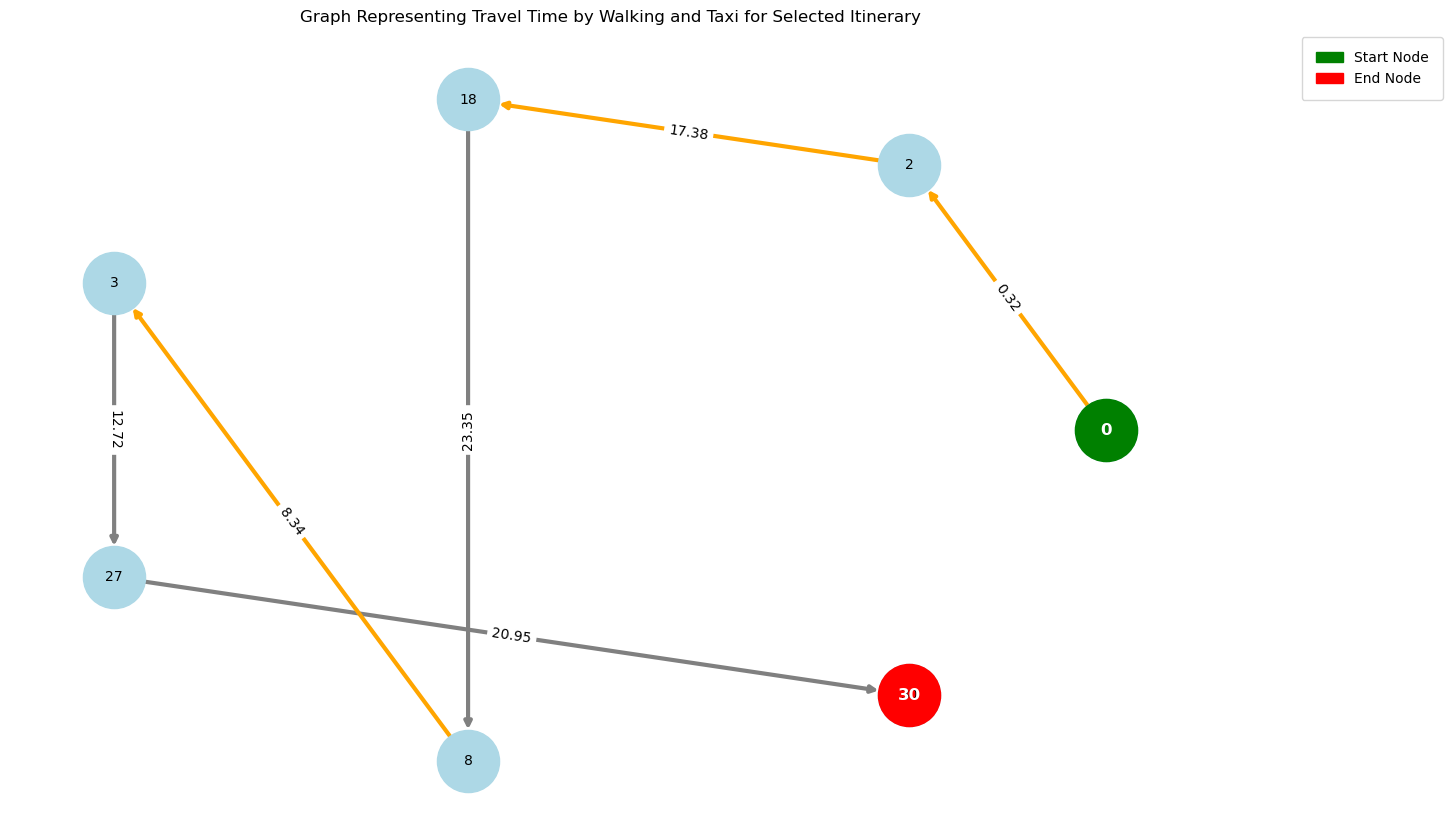

In [111]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G_walking = nx.DiGraph()  # Walking mode

# Add only nodes and edges from the selected itinerary
for start, end in selected_edges:
    if (start, end) in travel_times_walking or (start, end) in travel_times_taxi:
        time = travel_times_walking[(start, end)] if w[start, end].x > 0.5 else travel_times_taxi[(start, end)]
        G_walking.add_edge(start, end, weight=round(time, 2))  # Use correct travel time based on mode

# Generate positions for the graph using circular layout for equidistant nodes
pos = nx.circular_layout(G_walking)  # Ensures nodes are equispaced

# Identify start and end nodes
start_node = starting_poi  # First node in the itinerary
end_node = ending_poi # Last node in the itinerary

# # Determine travel mode for each edge
edge_colors = ["gray" if w[(start, end)].x > 0.5 else "orange" for start, end in G_walking.edges()]
edge_widths = [3] * len(G_walking.edges())  # Increase edge width for visibility

# Plot Walking Graph
plt.figure(figsize=(12, 8))
nx.draw(G_walking, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=edge_widths, node_size=2000, font_size=10)
edge_labels_walking = nx.get_edge_attributes(G_walking, 'weight')
nx.draw_networkx_edge_labels(G_walking, pos, edge_labels=edge_labels_walking, font_size=10)

# Highlight start and end nodes with separation in legend
nx.draw_networkx_nodes(G_walking, pos, nodelist=[start_node], node_color='green', node_size=2000)
nx.draw_networkx_nodes(G_walking, pos, nodelist=[end_node], node_color='red', node_size=2000)

# Manually create legend with separate entries
import matplotlib.patches as mpatches
start_patch = mpatches.Patch(color='green', label='Start Node')
end_patch = mpatches.Patch(color='red', label='End Node')
plt.legend(handles=[start_patch, end_patch], loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=10, frameon=True, borderpad=1)

# Draw labels for start and end nodes separately with white font color
nx.draw_networkx_labels(G_walking, pos, labels={start_node: str(start_node)}, font_color="white", font_size=12, font_weight="bold")
nx.draw_networkx_labels(G_walking, pos, labels={end_node: str(end_node)}, font_color="white", font_size=12, font_weight="bold")

plt.title("Graph Representing Travel Time by Walking and Taxi for Selected Itinerary")
plt.show()


In [112]:
print(model.SolCount)  # Number of optimal solutions found

10


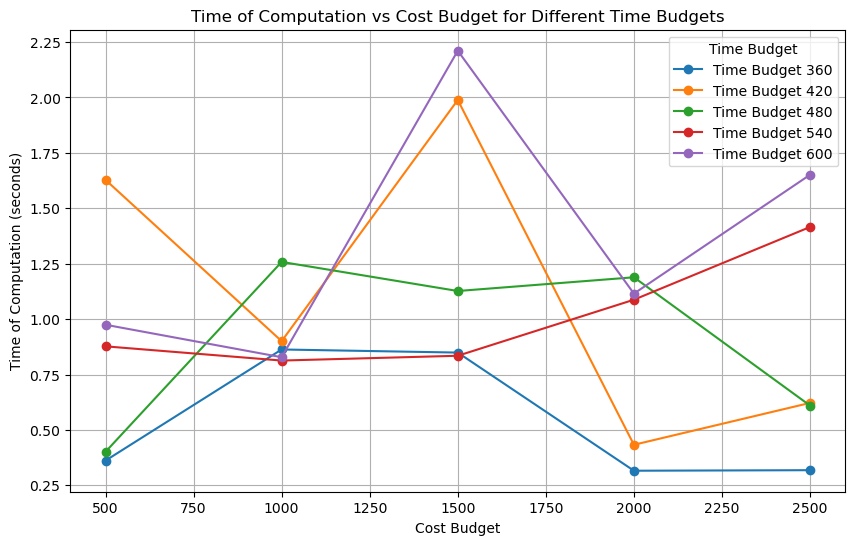

In [216]:
import pandas as pd
import matplotlib.pyplot as plt

  

filePath="/Users/priyanshukumarjha/Downloads/Data Record.xlsx"

def plot_time_vs_cost(file_path):
    df=pd.read_excel(filePath,sheet_name="Delhi")
    
    # Ensure column names match the expected format
    required_columns = ["Cost Budget", "Time Budget", "Time of Computation (seconds)"]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing column: {col} in the input file.")
    
    # Plot setup
    plt.figure(figsize=(10, 6))
    time_budgets = sorted(df["Time Budget"].unique())
    
    # Plot lines for each time budget
    for time_budget in time_budgets:
        subset = df[df["Time Budget"] == time_budget]
        plt.plot(subset["Cost Budget"], subset["Time of Computation (seconds)"], marker='o', linestyle='-', label=f'Time Budget {time_budget}')
    
    plt.xlabel("Cost Budget")
    plt.ylabel("Time of Computation (seconds)")
    plt.title("Time of Computation vs Cost Budget for Different Time Budgets")
    plt.legend(title="Time Budget")
    plt.grid(True)
    plt.show()

# Example usage
# file_path = "path/to/your/data.csv"  # Update with actual path
plot_time_vs_cost(filePath)
